In [1]:
using Distributions, Plots, Plots.PlotMeasures, Printf, Random, RxInfer, StableRNGs

# Generative process

We have a generative process that, for any hidden state $x \in \mathbb{R}$, generates a random outcome according to

$$y \sim \mathcal{N}(g_{\mathcal{E}}(x, \mathbf{\beta}), \sigma_y^2)$$

where:

 - $\pmb{\beta} = [\beta_0, \beta_1]^\top$
 - $g_{\mathcal{E}}(x, \pmb{\beta}) = \beta_0 + \beta_1 x$ is the generating function for the generative process
 - for any $\mu$ and $\sigma^2$, $\mathcal{N}(\mu, \sigma^2)$ is the univariate Gaussian with mean $\mu$ and variance $\sigma^2$
 - $\sigma_y^2$ is a particular, fixed variance for the process

An equivalent formulation is:

$$y = g_{\mathcal{E}}(x, \pmb{\beta}) + \omega_y$$

where $\omega_y \sim \mathcal{N}(0, \sigma^2)$ is a zero-mean Gaussian noise term.

As in section 2.1 of the Fundamentals of Active Inference draft, we assume that there is a single, true, fixed latent state $x^{\ast}$

Note: below, in order to make the numbers nicer, we do this in reverse, by specifying the observation $y$, and generating a random $x$ corresponding to this. This can be done by noting:

$$y = g_{\mathcal{E}}(x, \pmb{\beta}) + \omega_y = \beta_0 + \beta_1 x + \omega_y$$

Since $\omega_y$ has zero-mean and a Gaussian is symmetric, we can re-arrange this to:

$$x = - \frac{\beta_0}{\beta_1} + \frac{1}{\beta_1} y + \frac{1}{\beta_1} \omega_y$$

Since $\text{var}[\alpha x] = \alpha^2 \text{var}[x]$ for any $\alpha \in \mathbb{R}$ and any random variable $x$, we have that

$$\frac{1}{\beta_1} \omega_y \sim \mathcal{N}(0, \frac{\sigma_y^2}{\beta_1^2})$$

# Generative model

The above is written from the omniscient view of someone with access to the true state of the world. As mere agents, the true state is hidden from us. We seek to model and infer this state. Namely, we can establish a prior model $p(x)$ of the true state, an observation model $p(y|x)$ of observations conditional on state, and use the product rule from probability to construct the joint distribution over states and observations:

$$p(x, y) = p(y | x) p(x)$$

Pretending we didn't just formally define the generative process above, let's assume the agent uses prior knowledge somehow and "guesses" that a linear Gaussian observation model would work well:

$$p(y | x) = \mathcal{N}(y | g_{\mathcal{M}}(x, \mathbf{\gamma}), \eta_y^2)$$

where:

 - $\pmb{\gamma} = [\gamma_0, \gamma_1]^\top$
 - $g_{\mathcal{M}}(x, \pmb{\gamma}) = \gamma_0 + \gamma_1 x$ is our model of the process' generating function
 - $\eta_y^2$ is a fixed variance of the observation model

For the prior, we assume a Gaussian:

$$p(x) = \mathcal{N}(x | \mu_x, \sigma_x^2)$$

This modeling assumption reflects a belief that the hidden state is a continuous variable that can take on any real value $x \in (- \infty, + \infty)$. Different beliefs might lead us to different choice of prior (e.g. a log-normal prior for $x \in (0, \infty)$, or a categorical prior for a discrete $x$)

In [2]:
function make_linear_gaussian(a, b, v, x, rng)
    num_samples = length(x)
    y = a .+ b * x .+ randn(rng, num_samples) * sqrt(v)
    return x, y
end

function generative_process(x, β, var_y, rng)
    xs = [x]
    return make_linear_gaussian(β[1], β[2], var_y, xs, rng)
end

function inv_generative_process(y, β, var_y, rng)
    β_inv = [-β[1]/β[2], 1.0/β[2]]
    var_inv = var_y / β[2]^2
    ys = [y]
    return make_linear_gaussian(β_inv[1], β_inv[2], var_inv, ys, rng)
end

@model function gen_model(n::Int64, mu_x::Float64, stddev_x::Float64, γ, stddev_y)
   y = datavar(Float64, n)
   x ~ NormalMeanVariance(mu_x, stddev_x)

   for i in 1:n
       y[i] ~ NormalMeanVariance(γ[1] + γ[2] * x, stddev_y)
   end
end

function generative_model(ys, mu_x::Float64, stddev_x::Float64, γ::Vector{Float64}, stddev_y::Float64, rng)
    g_M = x -> γ[1] + γ[2] * x

    prior = Normal(mu_x, stddev_x)
    likelihood = x -> Normal(g_M(x), stddev_y)
    
    xs = range(0, 6, length = 1000)

    plot!(xs, (x) -> pdf.(prior, x), fillalpha=0.3, fillrange=0, label="p(x)", c=1)
    plot!(xs, (x) -> pdf.(likelihood(x), ys[1]), fillalpha=0.3, fillrange=0, label="p(y|x)", c=2)

    # use eval() to workaround limitation of the @model macro

    result = infer(
        model = gen_model(length(ys), mu_x, stddev_x, γ, stddev_y), 
        data  = (y = ys, ),
        free_energy  = true
    )

    posterior = result.posteriors[:x]

    plot!(xs, (x) -> pdf(posterior, x), fillalpha=0.3, fillrange = 0, label="p(x|y)", c=3)
end;

In [3]:
seed = 299792458

rng = StableRNG(seed)

StableRNGs.LehmerRNG(state=0x00000000000000000000000023bcf095)

In [4]:
# example 2b from FOAI
β = [3.0, 2.0]
var_y = 1

1

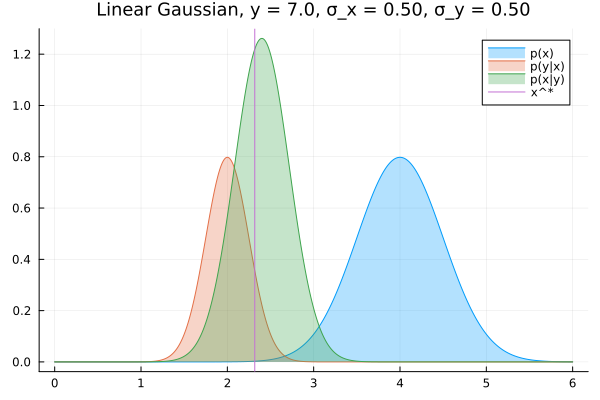

In [5]:
y_data, x_data = inv_generative_process(7.0, β, var_y, rng)

make_plot_title(y, stddev_x, stddev_y) = "Linear Gaussian, y = $(@sprintf("%.1f", y)), σ_x = $(@sprintf("%.2f", stddev_x)), σ_y = $(@sprintf("%.2f", stddev_y))"

# assume we've already learned the correct γ parameters, somehow
mu_x = 4.0
stddev_x = sqrt(0.25)
γ = [3.0, 2.0]
stddev_y = sqrt(0.25)


plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

# Precision

We can alternatively parameterize any Gaussian by defining the **precision** as the inverse variance:

$$\lambda := \frac{1}{\sigma^2}$$

High variance = low precision, and vice versa.

Above, we considered the case of equal prior and likelihood precision/variance. We can consider two alternative cases:

 - high prior precision and low likelihood precision, or $\sigma_x^2 < \sigma_y^2$
 - and low prior precision and high likelihood precision, or $\sigma_x^2 > \sigma_y^2$

## High prior precision, low likelihood precision

The model relies primarily on the prior.

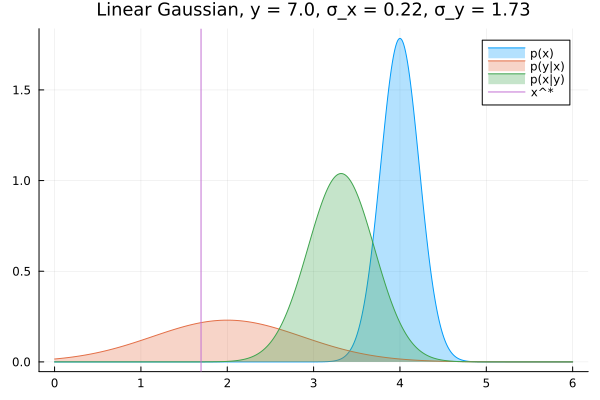

In [6]:
# high prior precision, low likelihood precision

mu_x = 4.0
stddev_x = sqrt(0.05)
γ = [3.0, 2.0]
stddev_y = sqrt(3.0)

y_data, x_data = inv_generative_process(7.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

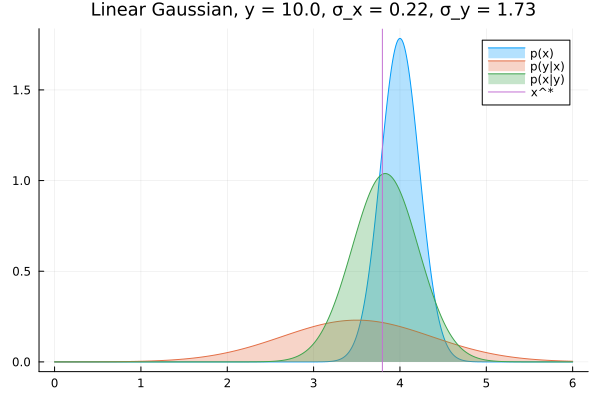

In [7]:
y_data, x_data = inv_generative_process(10.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

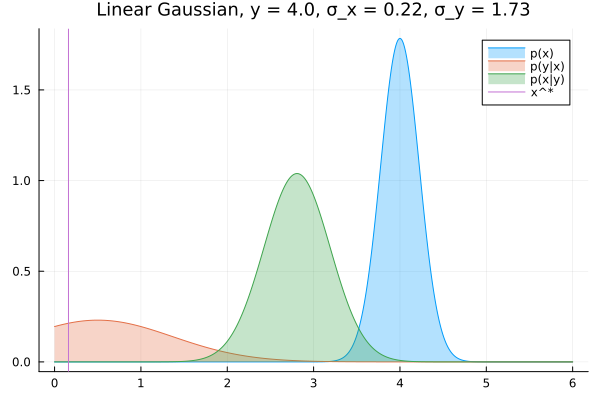

In [8]:
y_data, x_data = inv_generative_process(4.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

## Low prior precision, high likelihood precision

The model relies primarily on the observation.

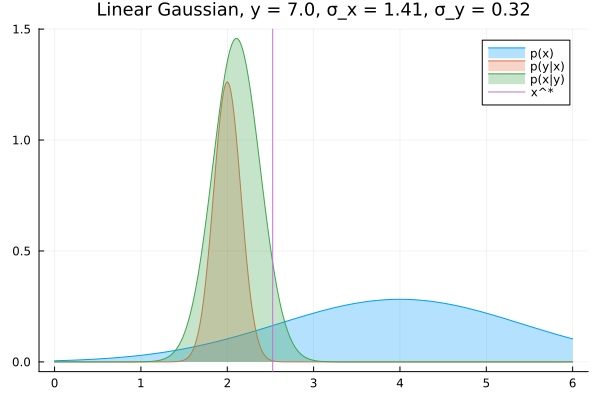

In [9]:
mu_x = 4.0
stddev_x = sqrt(2)
γ = [3.0, 2.0]
stddev_y = sqrt(0.1)

y_data, x_data = inv_generative_process(7.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

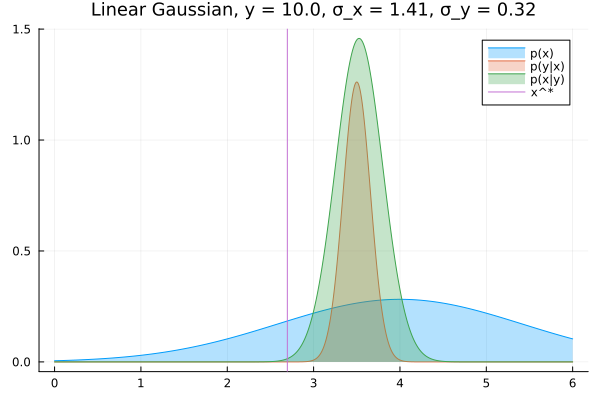

In [10]:
y_data, x_data = inv_generative_process(10.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

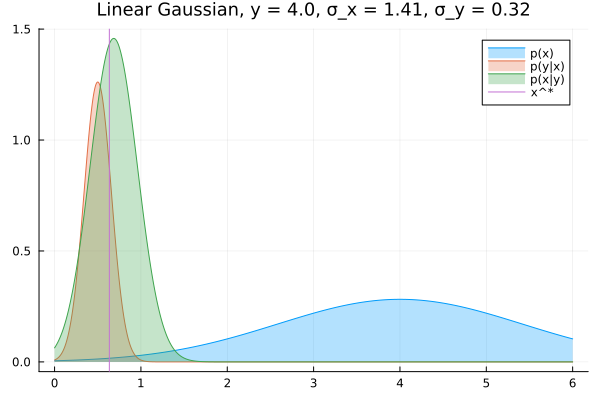

In [11]:
y_data, x_data = inv_generative_process(4.0, β, var_y, rng)
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)

# Non-linear generating function

Consider a new generative process with mostly the same setup as before, except that now we have a generating function which is a quadratic function of $x$:

$$g_{\mathcal{E}}(x, \pmb{\beta}) = \beta_0 + \beta_1 x^2$$

The process for generating $x$ from $y$ is now slightly more complicated:

$$y = g_{\mathcal{E}}(x, \pmb{\beta}) + \omega_y = \beta_0 + \beta_1 x^2 + \omega_y$$

$$x^2 = - \frac{\beta_0}{\beta_1} + \frac{1}{\beta_1} y + \frac{1}{\beta_1} \omega_y$$

$$x = \sqrt{- \frac{\beta_0}{\beta_1} + \frac{1}{\beta_1} y + \frac{1}{\beta_1} \omega_y}$$

Where we assume $x \geq 0$, which allows us to take the positive branch of the square root.

Since $\text{var}[\alpha x] = \alpha^2 \text{var}[x]$ for any $\alpha \in \mathbb{R}$ and any random variable $x$, we have that

$$\frac{1}{\beta_1} \omega_y \sim \mathcal{N}(0, \frac{\sigma_y^2}{\beta_1^2})$$


In [22]:
function inv_generative_process_quadratic(y, β, var_y, rng)
    β_inv = [-β[1]/β[2], 1.0/β[2]]
    var_inv = var_y / β[2]^2
    ys = [y]
    ys, xs = make_linear_gaussian(β_inv[1], β_inv[2], var_inv, ys, rng)
    @assert all(i -> i >= 0, xs) "Oops, we got a negative"
    return ys, map(sqrt, xs)
end

sq(x) = x^2

@model function gen_model2(n::Int64, mu_x::Float64, stddev_x::Float64, γ::Vector{Float64}, stddev_y::Float64)
   y = datavar(Float64, n)
   x ~ NormalMeanVariance(mu_x, stddev_x)

   for i in 1:n
       y[i] ~ NormalMeanVariance(γ[1] + γ[2] * sq(x), stddev_y)
   end
end

function generative_model2(ys, mu_x::Float64, stddev_x::Float64, γ::Vector{Float64}, stddev_y::Float64, rng)
    g_M = x -> γ[1] + γ[2] * x^2

    prior = Normal(mu_x, stddev_x)
    likelihood = x -> Normal(g_M(x), stddev_y)
    
    xs = range(0, 6, length = 1000)

    plot!(xs, (x) -> pdf.(prior, x), fillalpha=0.3, fillrange=0, label="p(x)", c=1)
    plot!(xs, (x) -> pdf.(likelihood(x), ys[1]), fillalpha=0.3, fillrange=0, label="p(y|x)", c=2)

    delta_meta = @meta begin
        sq() -> DeltaMeta(method = Linearization(), inverse = sqrt)
    end

    result = infer(
        model = gen_model2(length(ys), mu_x, stddev_x, γ, stddev_y), 
        meta = delta_meta,
        data  = (y = ys, ),
        free_energy  = true
    )

    posterior = result.posteriors[:x]

    plot!(xs, (x) -> pdf(posterior, x), fillalpha=0.3, fillrange = 0, label="p(x|y)", c=3)
end;

[1.5125042240694027][3.0]

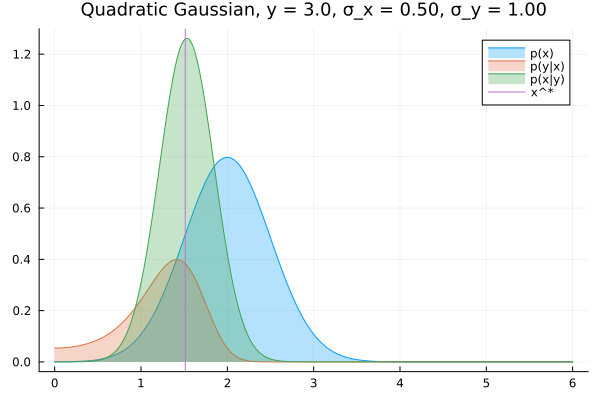

In [27]:
# uses the same values as example 2E
β = [1.0, 1.0]
var_y = 1.0

y_data, x_data = inv_generative_process_quadratic(3.0, β, var_y, rng)
print(x_data, y_data)

make_plot_title(y, stddev_x, stddev_y) = "Quadratic Gaussian, y = $(@sprintf("%.1f", y)), σ_x = $(@sprintf("%.2f", stddev_x)), σ_y = $(@sprintf("%.2f", stddev_y))"

# assume we've already learned the correct γ parameters, somehow
mu_x = 2.0
stddev_x = sqrt(0.25)
γ = [1.0, 1.0]
stddev_y = sqrt(1.0)

plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model2(y_data, mu_x, stddev_x, γ, stddev_y, rng)
vline!(x_data, label="x^*", c=4)